In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, COMMON_STAGES
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
set_global_seed(42)
data_path_sat1 = Path("../data/sat1/stage_data_100hz.nc")
dataset_sat1 = xr.load_dataset(data_path_sat1)

In [3]:
# Split before merging to ensure equal participant distribution across datasets and normalization within dataset
shape_topological = False
train_data_sat1, val_data_sat1, test_data_sat1 = split_data_on_participants(
    dataset_sat1, 60, norm_min1_to_1
)

In [5]:
chk_path = Path("../models/gru100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(train_data_sat1.channels),
    "n_samples": len(train_data_sat1.samples),
    "n_classes": len(train_data_sat1.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

In [6]:
train_dataset = SAT1Dataset(
    train_data_sat1, shape_topological=shape_topological, labels=COMMON_STAGES
)
val_dataset = SAT1Dataset(
    val_data_sat1, shape_topological=shape_topological, labels=COMMON_STAGES
)
test_dataset = SAT1Dataset(
    test_data_sat1, shape_topological=shape_topological, labels=COMMON_STAGES
)

In [7]:
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

In [18]:
# (epoch, sample, sample, class)
# probabilities = np.full(
#     (
#         len(test_dataset),
#         len(test_merge.samples),
#         len(test_merge.samples),
#         len(COMMON_STAGES),
#     ),
#     np.nan,
# )
torch.set_printoptions(sci_mode=False)
proba_list = []
model = model.eval()
for batch in test_loader:
    # print(batch[0].shape)
    # (batch_size, 300, 20)
    for epoch, true in zip(batch[0], batch[1]):
        proba_epoch = np.full(
            (
                len(test_data_sat1.samples),
                len(test_data_sat1.samples),
                len(test_data_sat1.labels),
            ),
            np.nan,
        )
        # Create batch of every combination of start/length
        # Epoch ends at first -1 in truth labels
        end_idx = (true == -1).nonzero().squeeze()[0]
        print(end_idx)
        print(true)
        sub_batch = []
        for start in range(end_idx):
            slices = [
                epoch[start : start + length]
                for length in range(1, end_idx - start + 1)
            ]
            padded = [
                torch.nn.functional.pad(
                    slice,
                    (0, 0, 0, len(test_data_sat1.samples) - slice.size(0)),
                    value=MASKING_VALUE,
                )
                for slice in slices
            ]
            padded = torch.stack(padded).to(DEVICE)
            pred = model(padded)
            pred = torch.nn.Softmax(dim=1)(pred)
            # max_vals, _ = torch.max(pred, dim=1, keepdim=True)
            # mask = pred == max_vals
            # pred[~mask] = float("nan")
            proba_epoch[start, start : start + pred.size(0)] = (
                pred.detach().cpu().numpy()
            )
            # print(pred.shape)
            # print(torch.argmax(pred, dim=1))
            # plt.plot(pred.detach().cpu().numpy())
            # plt.legend(COMMON_STAGES)
            # plt.show()
            # break
        break
    break

tensor(58)
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  3,  3,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1])


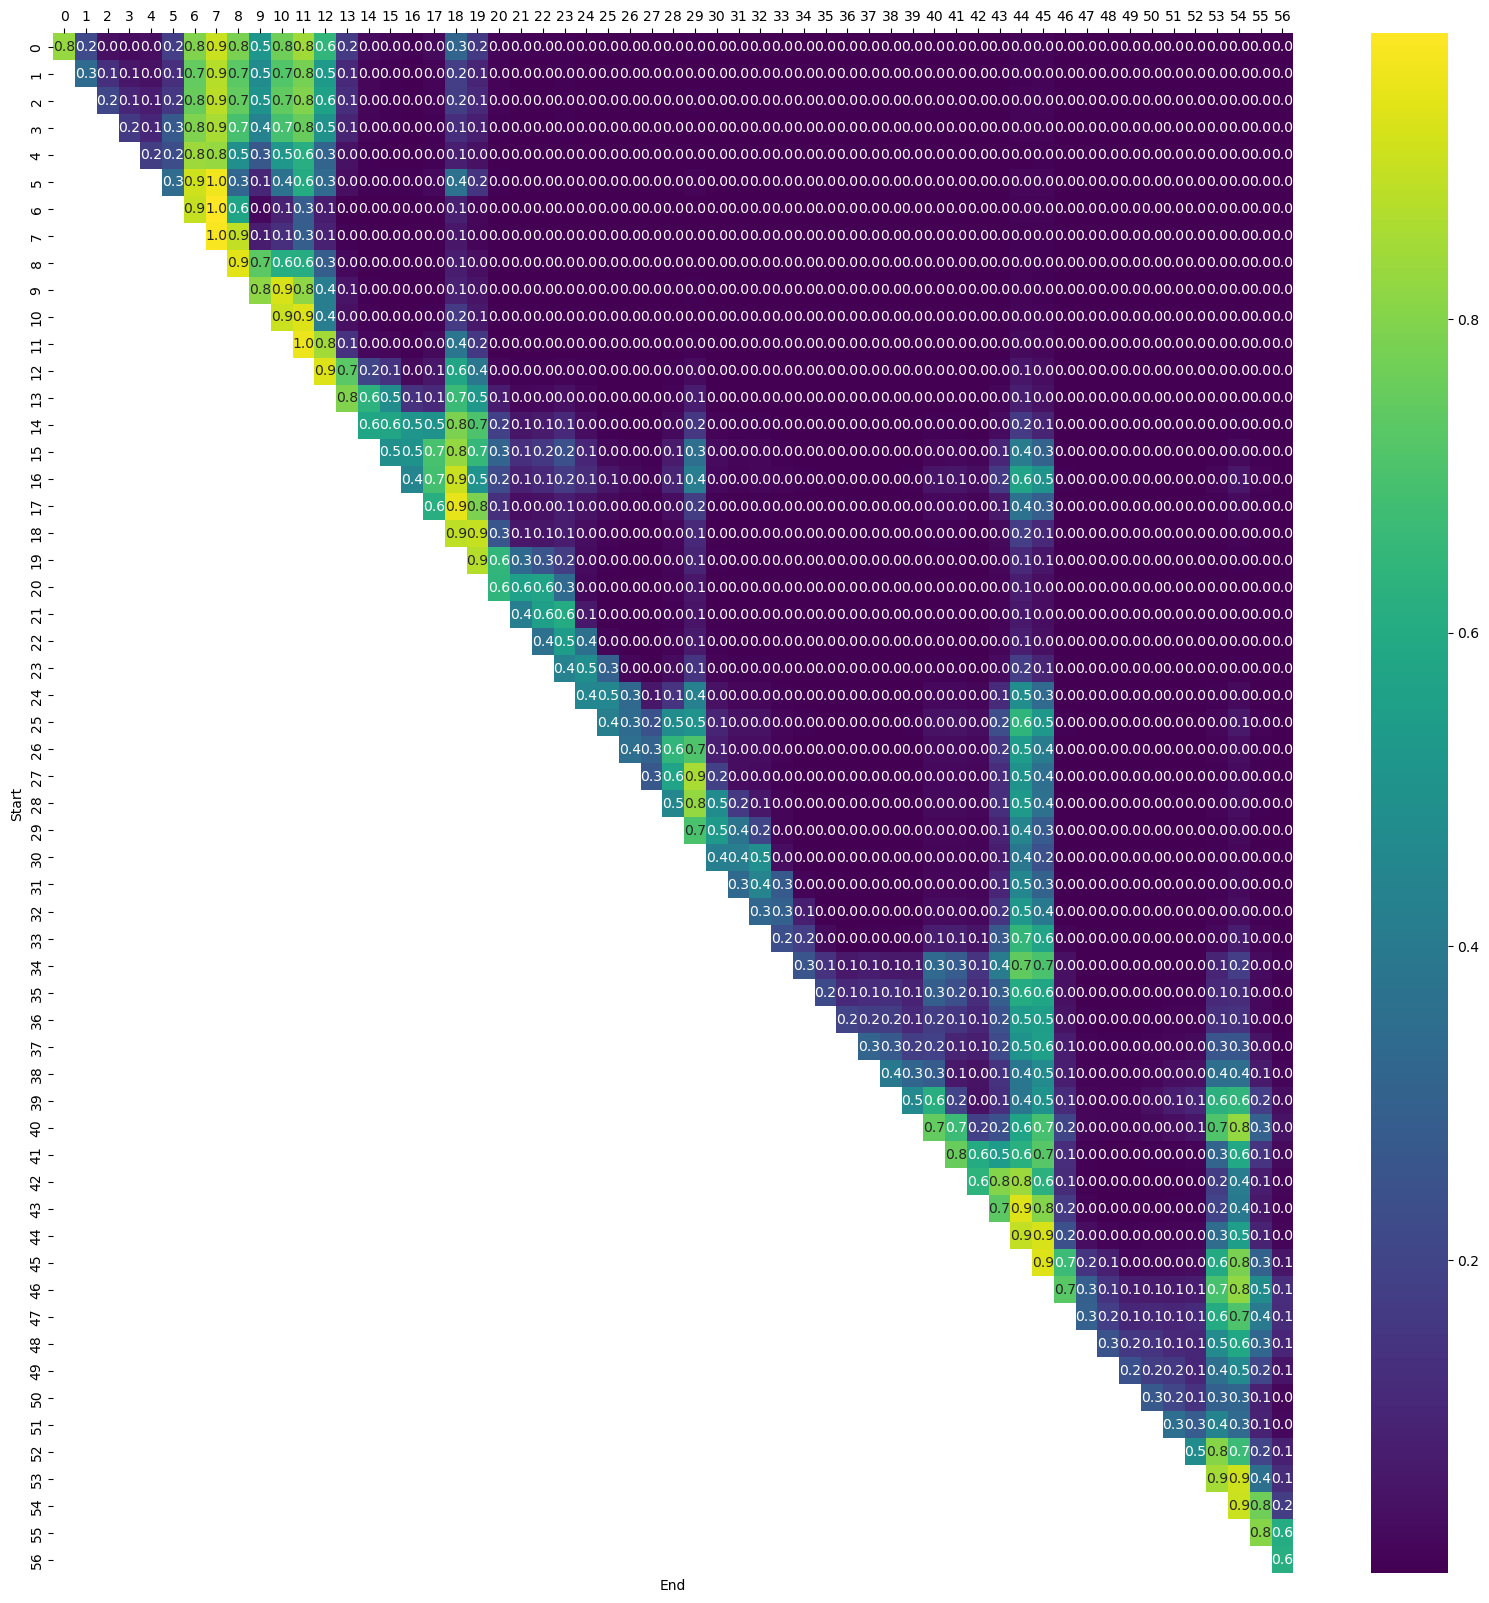

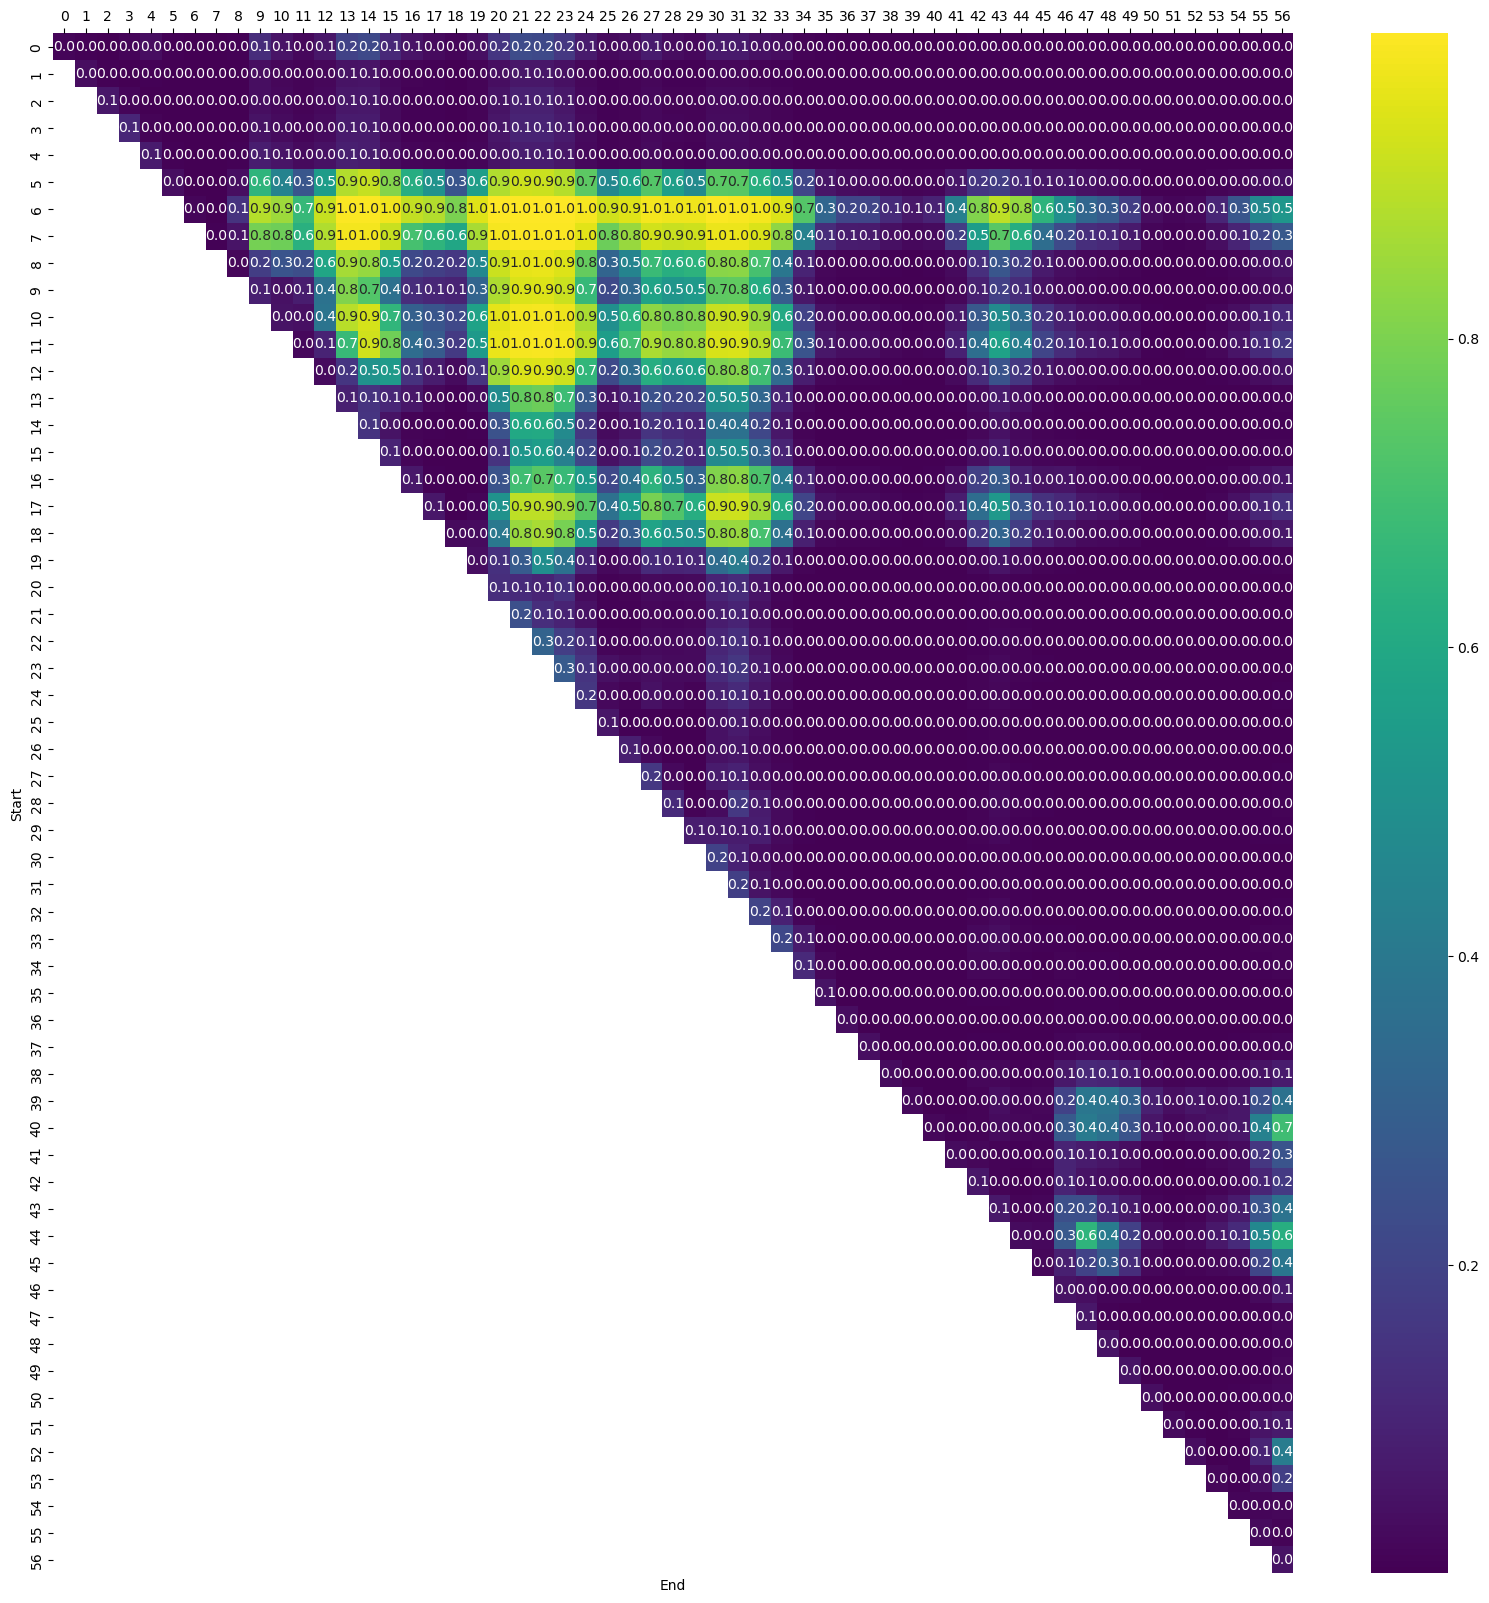

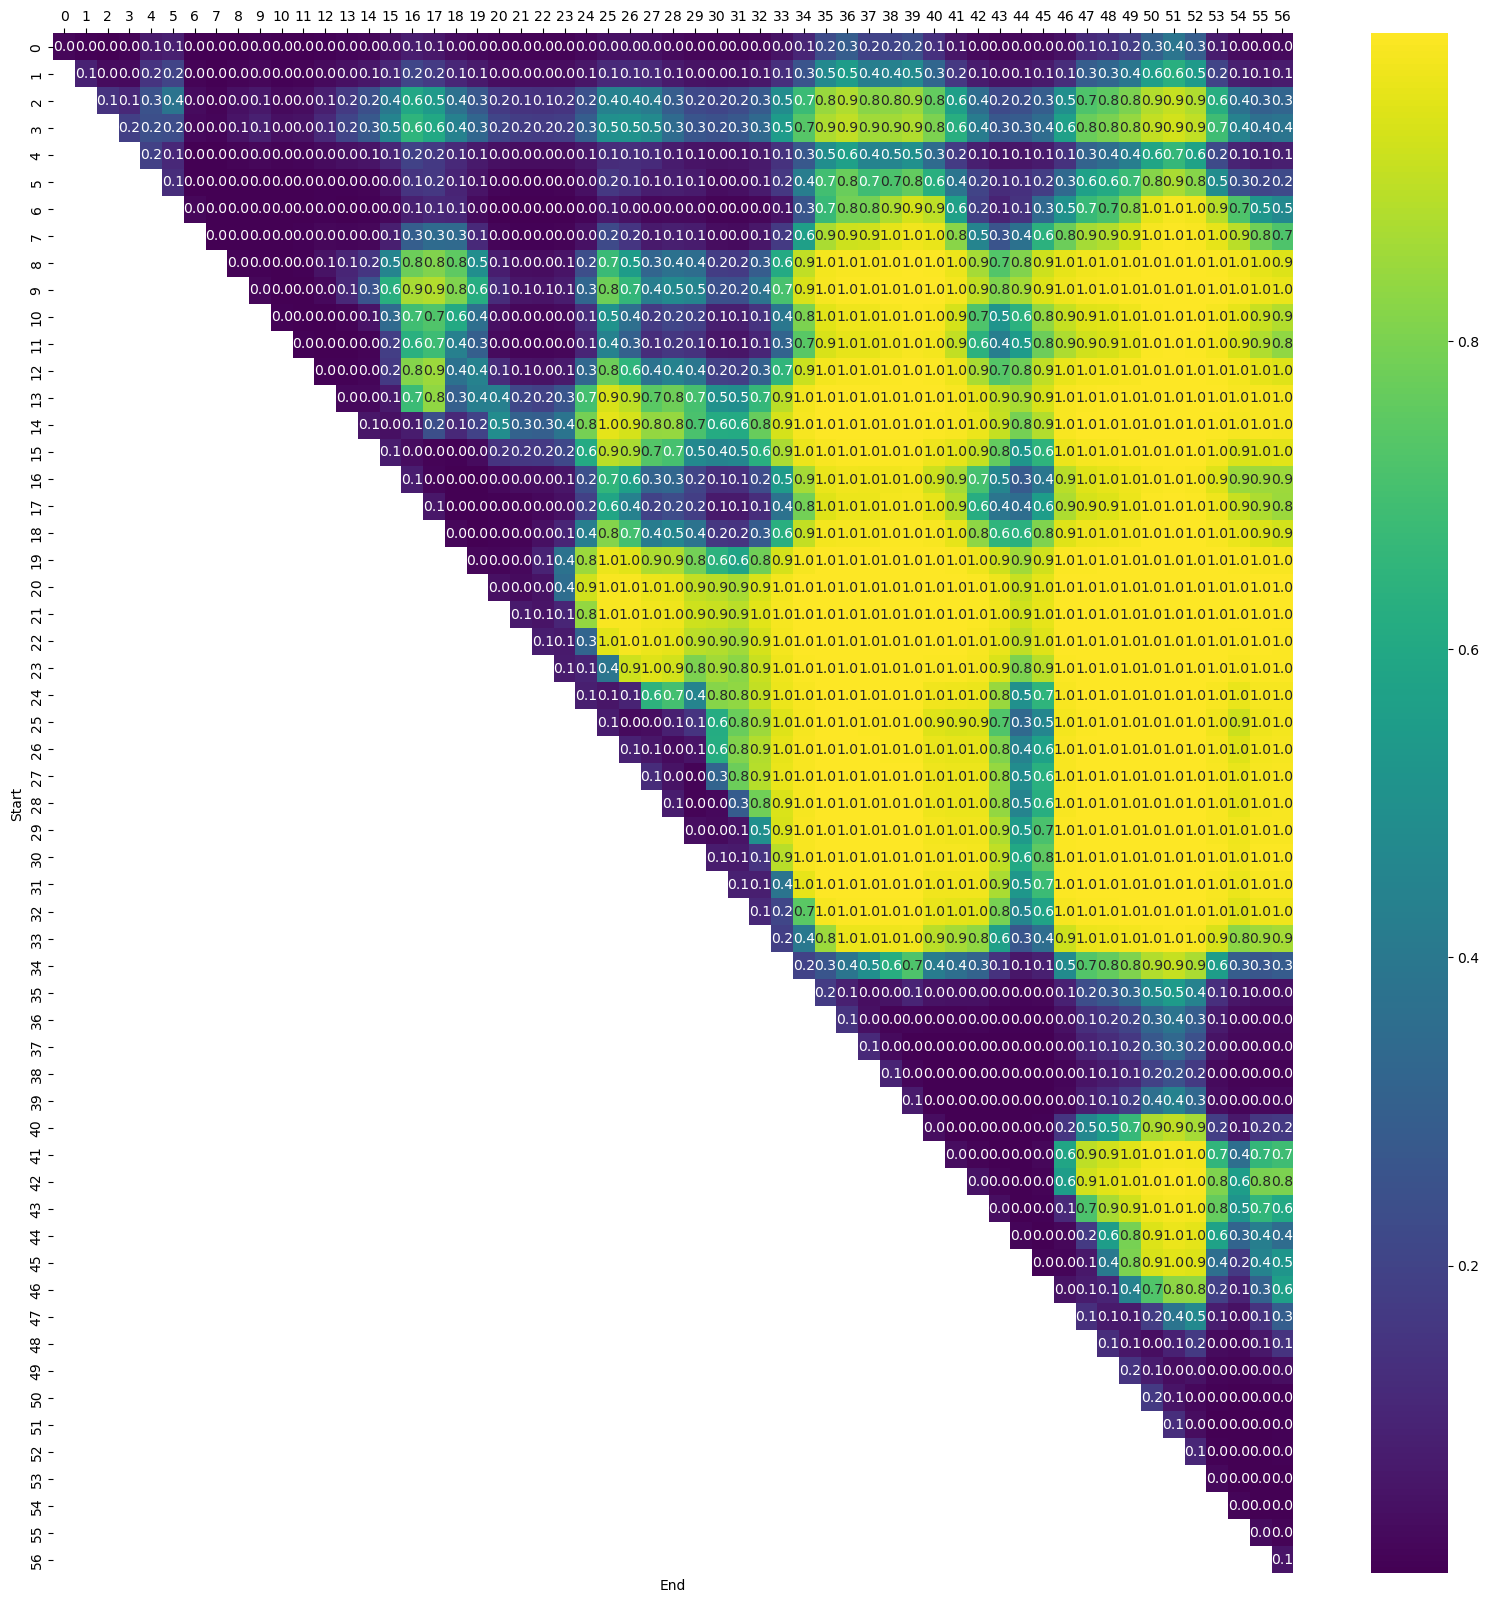

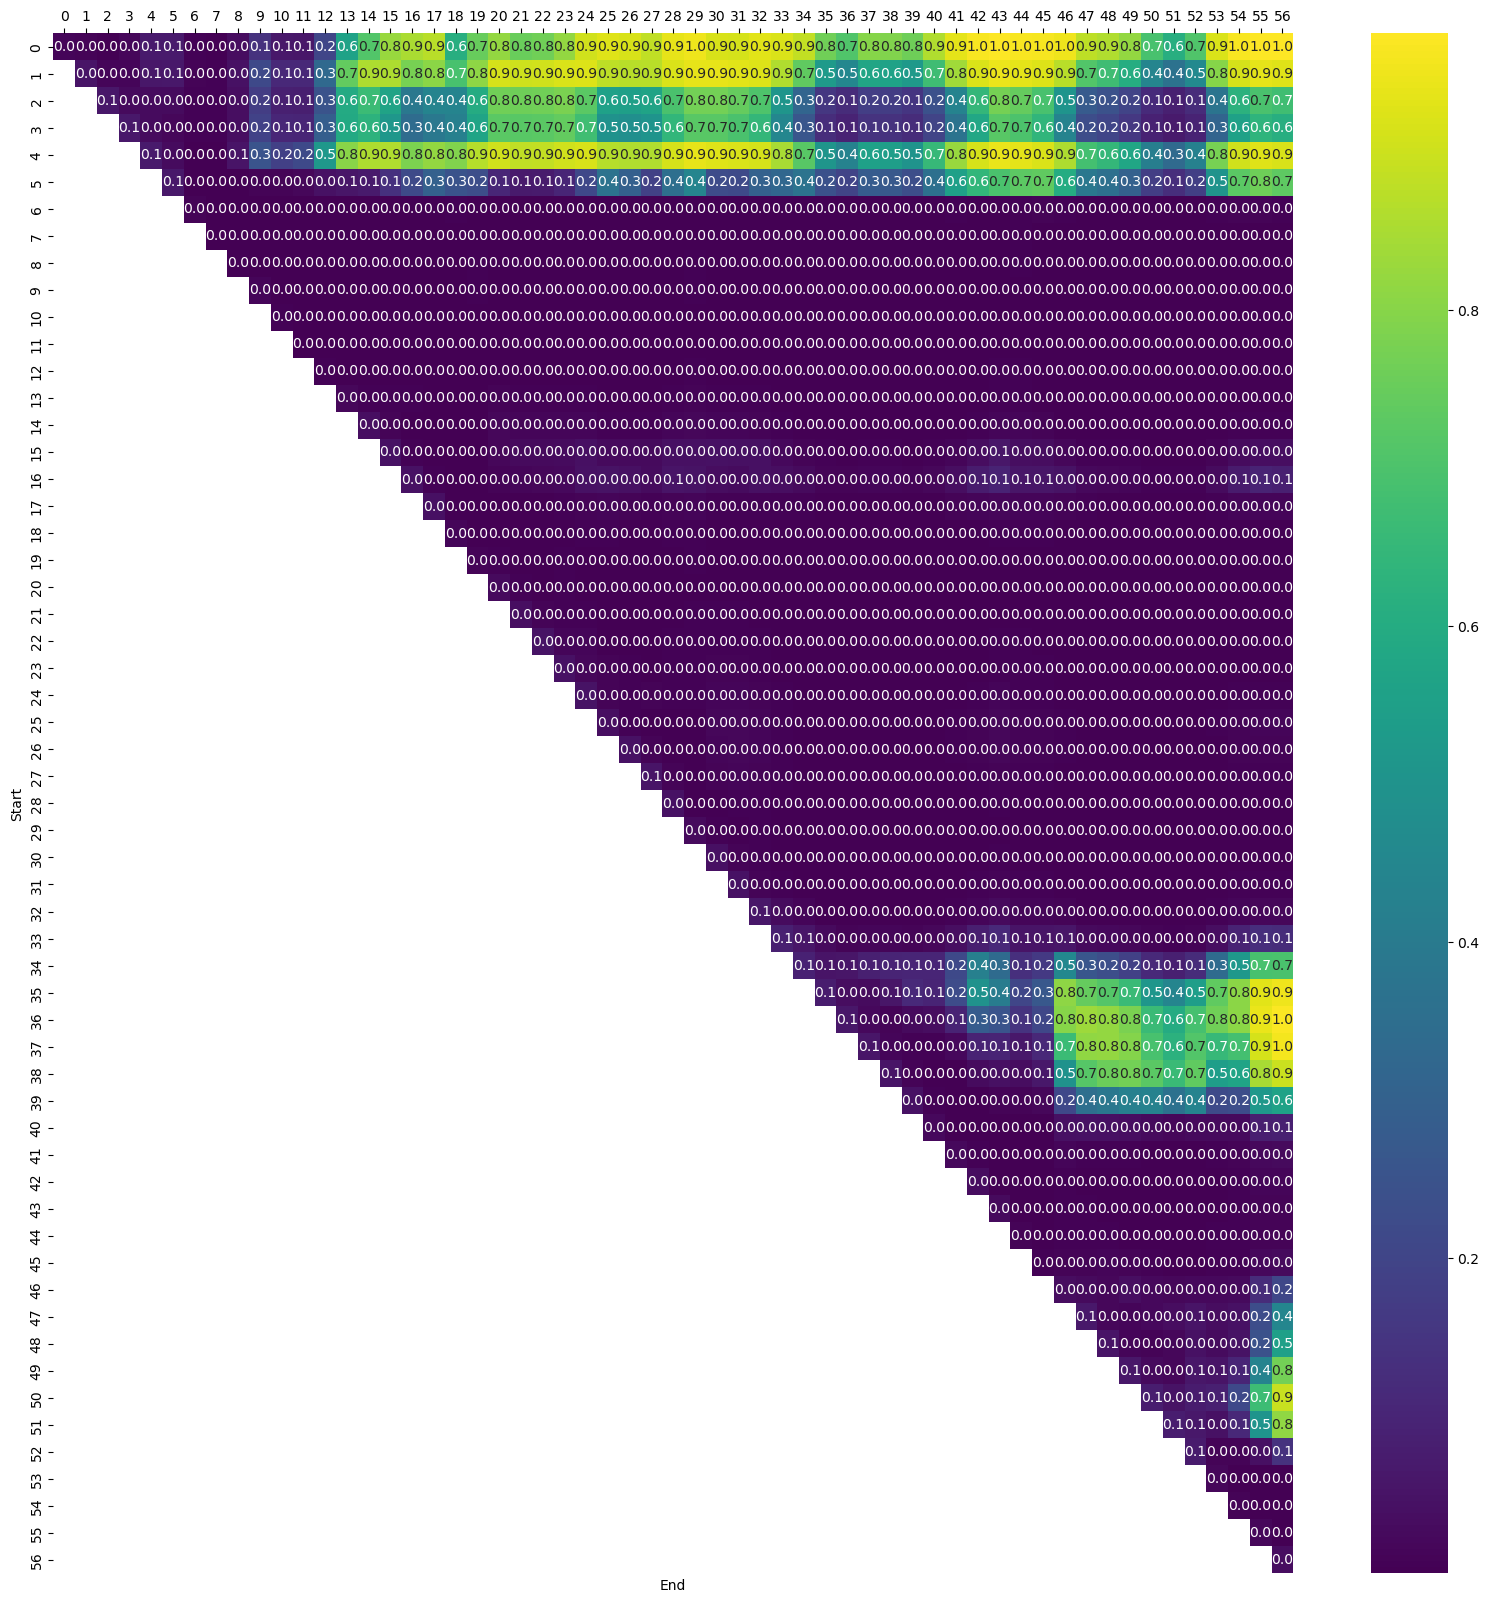

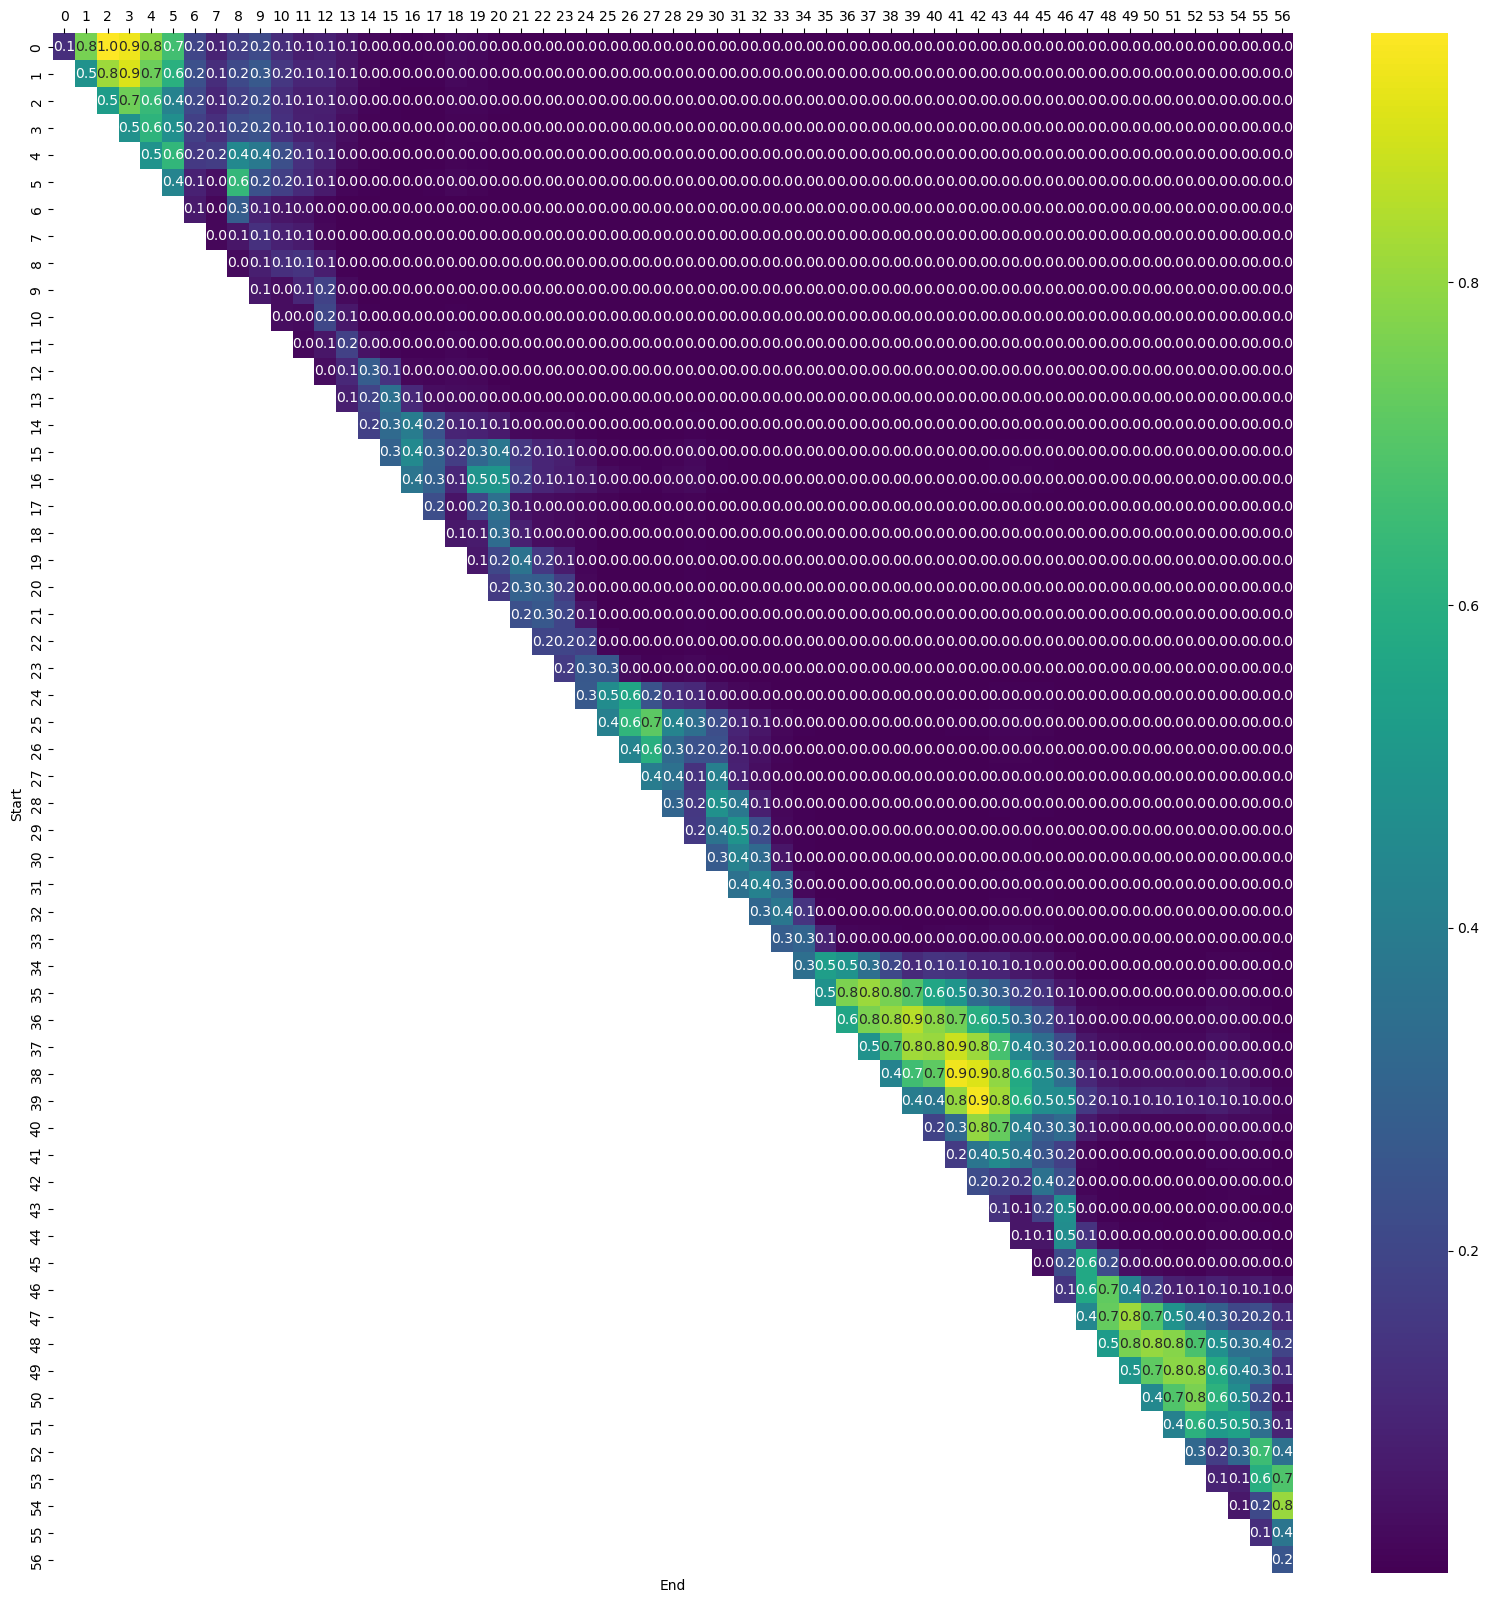

In [25]:
endrange = 57
for i in range(proba_epoch.shape[2]):
    plt.figure(figsize=(20, 20))
    ax = sns.heatmap(
        proba_epoch[0:endrange, 0:endrange, i],
        annot=True,
        xticklabels=range(0, endrange),
        yticklabels=range(0, endrange),
        fmt=".1f",
        cmap="viridis",
    )
    ax.xaxis.tick_top()
    plt.xlabel("End")
    plt.ylabel("Start")
    # plt.imshow(proba_epoch[0:20,0:20,0], cmap="viridis", fmt="c")
    # plt.xticks(range(0, 20))
    # plt.yticks(range(0, 20))
    # plt.colorbar()
    plt.show()

58
(199,)
58
(199,)
58
(199,)
58
(199,)
58
(199,)


/tmp/ipykernel_7451/2055514544.py:6: RuntimeWarning: Mean of empty slice
  label_data = np.nanmean(proba_epoch[:, :, label], axis=0)


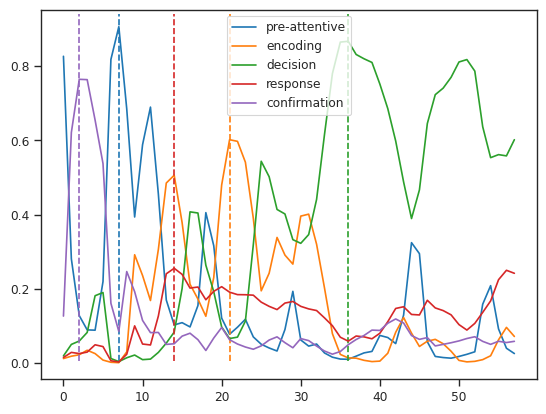

In [26]:
colors = sns.color_palette(None, n_colors=len(COMMON_STAGES))
sns.set_style("ticks")
sns.set_context("paper")

for label in range(0, proba_epoch.shape[2]):
    label_data = np.nanmean(proba_epoch[:, :, label], axis=0)
    nan_idx = np.isnan(proba_epoch[0, :, 0]).nonzero()[0][0]
    print(nan_idx)
    print(label_data.shape)
    plt.plot(label_data)
    # print(label_data)
    if np.nanmax(label_data) > 0.0:
        plt.axvline(
            x=np.nanargmax(label_data),
            ymin=0.05,
            ymax=0.99,
            color=colors[label],
            label="_nolegend_",
            linestyle="--",
        )
plt.legend(COMMON_STAGES)
plt.show()

/tmp/ipykernel_1661/464918187.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(proba_epoch[0:100,0:100,0], axis=0))


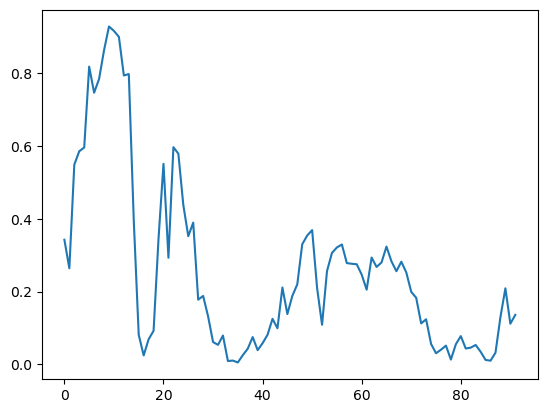

In [87]:
plt.plot(np.nanmean(proba_epoch[0:100, 0:100, 0], axis=0))

/tmp/ipykernel_1661/3158977359.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(proba_epoch[0:100,0:100,0], axis=1))


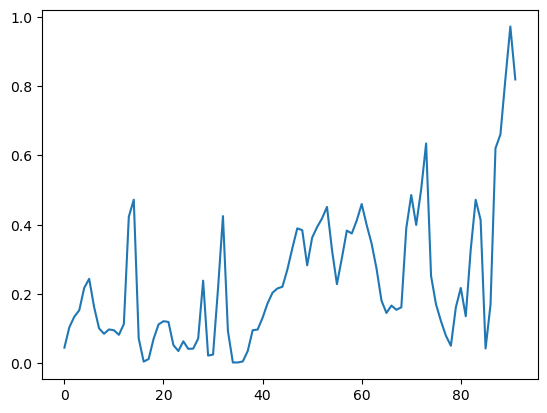

In [88]:
plt.plot(np.nanmean(proba_epoch[0:100, 0:100, 0], axis=1))

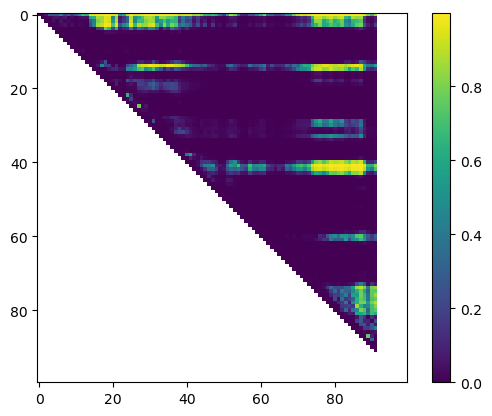

In [75]:
plt.imshow(proba_epoch[0:100, 0:100, 3])
plt.colorbar()
plt.show()

In [185]:
common_labels = [
    "confirmation",
    "decision",
    "pre-attentive",
    "familiarity",
    "response",
    "memory",
    "encoding",
]

In [186]:
split_data_path_sat1 = Path("../data/sat1/split_stage_data_100hz.nc")
split_dataset_sat1 = xr.load_dataset(split_data_path_sat1)
split_dataset_sat1["channels"] = [
    c.upper() for c in split_dataset_sat1["channels"].values
]
split_dataset_sat1 = split_dataset_sat1.reindex(channels=AR_SAT1_CHANNELS)
split_train_data, split_val_data, split_test_data = split_data_on_participants(
    split_dataset_sat1, 60, norm_min1_to_1
)

split_test_dataset = SAT1Dataset(
    split_test_data, shape_topological=shape_topological, labels=common_labels
)

split_test_loader = DataLoader(
    split_test_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

results, pred, true = test(model, split_test_loader, None)
pred = pred.cpu()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

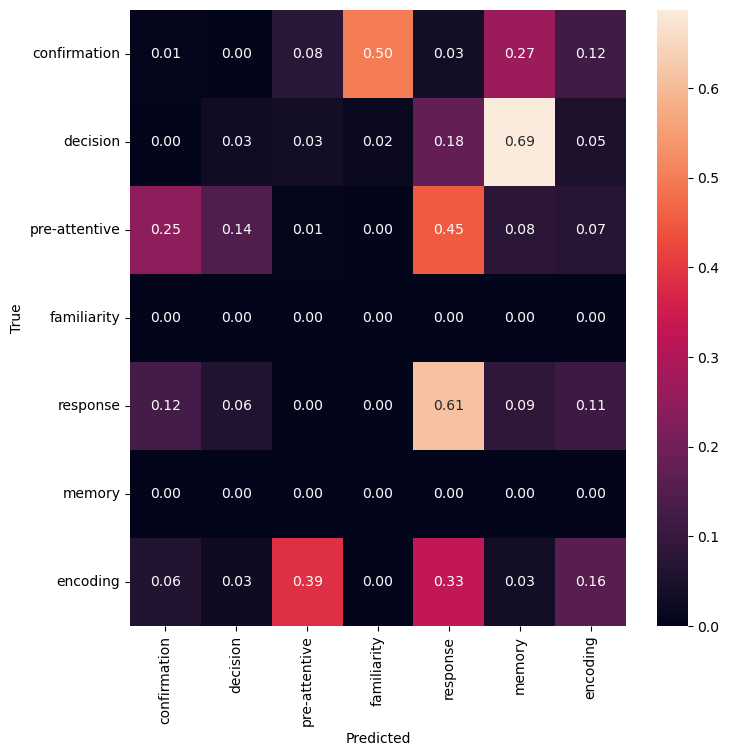

In [187]:
plot_confusion_matrix(true, pred, common_labels)